## CSC2515 Fall 2017 Paper by Krist Papadopoulos

### Boston Housing Dataset - Lasso and Random Forest Regression calculations

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.datasets import load_boston

In [0]:
class model(object):
    '''
    model object
    '''
    def __init__(self, clf, version, name, X, y):
        self.regress = clf
        self.version = version
        self.name = name
        self.X = (X - np.mean(X, axis = 0))/np.std(X, axis = 0)
        self.y = y

In [0]:
def model_cross_validation(model, kfold):
    X_train = model.X
    y_train = model.y
    kf = KFold(n_splits=kfold, shuffle=True, random_state = 42)
    predict = []
    cv_mse = []
    for j, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train)):
        cv_X_train, cv_X_test = X_train[cv_train_idx], X_train[cv_test_idx]
        cv_y_train, cv_y_test = y_train[cv_train_idx], y_train[cv_test_idx]   
        
        model.regress.fit(cv_X_train,cv_y_train)
        
        predict.append(model.regress.predict(cv_X_test))
        
        cv_mse.append(mean_squared_error(cv_y_test, model.regress.predict(cv_X_test)))
    
    if model.name == 'lasso':
        lasso_coef = model.regress.coef_
        return np.array(predict), np.array(cv_mse),lasso_coef
    
    elif model.name == 'random':
        random_feat_importance = model.regress.feature_importances_
        return np.array(predict), np.array(cv_mse), random_feat_importance
    
    else:
        pass

# Boston Data

In [0]:
boston = load_boston()
X = boston.data
y = boston.target
len(X)
boston.feature_names
X_df = pd.DataFrame(X, columns=boston.feature_names)
y_df = pd.DataFrame(y, columns=['SALEPRICE'])

In [0]:
df = pd.concat([X_df,y_df], axis=1)

In [0]:
df_filtered = df[df['SALEPRICE'] < 50]

In [0]:
#df_filtered.to_csv('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/df_filtered_boston.csv', header=True)

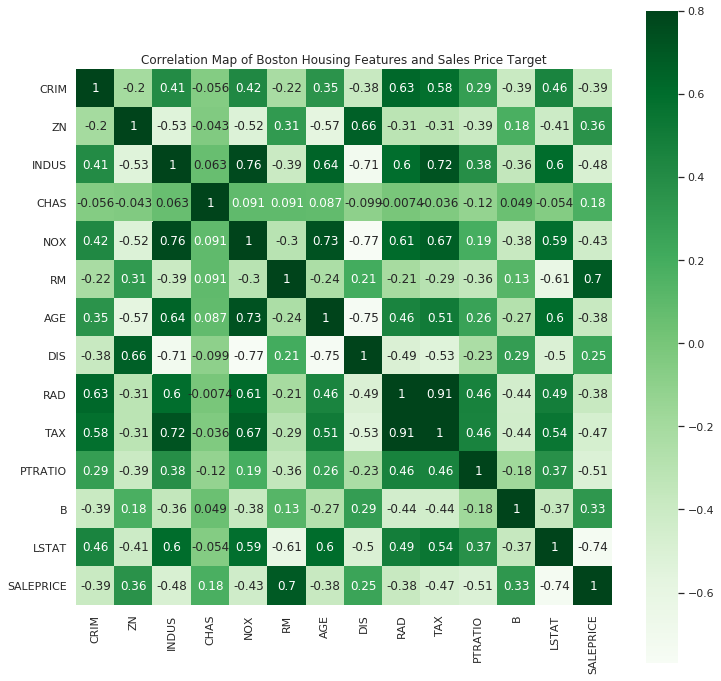

In [8]:
# Correlation Map with no Outlier Filtering

corrmat = pd.concat([X_df,y_df], axis=1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="Greens", annot=True)
plt.title("Correlation Map of Boston Housing Features and Sales Price Target")
plt.show()
#plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Lasso_Heat_Map.png', bbox_inches='tight')

Text(0.5, 1, 'Correlation Map of Boston Housing Features and Sales Price Target with Sale Price of 50 Filtered')

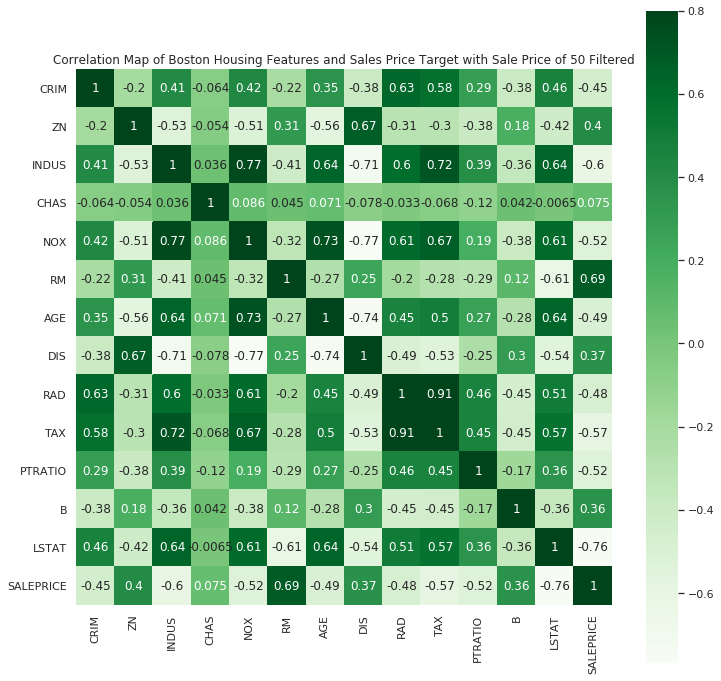

In [9]:
# Correlation Map with Outlier Filtering

corrmat_outlier_filtered = df_filtered.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat_outlier_filtered, vmax=.8, square=True, cmap="Greens", annot=True)
plt.title("Correlation Map of Boston Housing Features and Sales Price Target with Sale Price of 50 Filtered")

# Lasso Model

## No Filtering for Outlier

### Hyperparameter Tuning

In [0]:
def mse_cv(model,X,y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5)
    return mse

In [11]:
# cross validation, alpha regularization
alphas = [0.0001,0.0005,0.001, 0.0025, 0.005, 0.01, 0.02]
cv_lasso = [mse_cv(Lasso(alpha=alpha, max_iter=10000), X, y).mean() for alpha in alphas]
print("The minimum mean squared error is {} and it occurrs at regularization of {}".format(min(cv_lasso),alphas[np.argmin(cv_lasso)]))

The minimum mean squared error is 35.56711702765561 and it occurrs at regularization of 0.02


### Lasso CV Predictions

In [0]:
boston_lasso = model(Lasso(alpha=0.02, selection='random', random_state=42),1,'lasso',X,y)

In [0]:
boston_lasso_1_cv_predict, boston_lasso_1_cv_mse, lasso_coef = model_cross_validation(boston_lasso, 5)

In [14]:
boston_lasso_1_cv_mse

array([24.39839219, 20.93280487, 26.48653798, 23.28757272, 22.28957383])

In [15]:
boston_lasso_1_cv_mse.sum()/5

23.478976317773643

In [16]:
np.std(boston_lasso_1_cv_mse)/np.sqrt(5)

0.8443945841818173

In [17]:
max(boston_lasso_1_cv_mse) - min(boston_lasso_1_cv_mse)

5.553733108678589

In [18]:
dict(zip(boston.feature_names,lasso_coef))

{'AGE': 0.20450778803255512,
 'B': 0.7758666911978754,
 'CHAS': 0.5857482530000105,
 'CRIM': -0.8401724674161571,
 'DIS': -3.1250248858031546,
 'INDUS': -0.1618364999872911,
 'LSTAT': -3.8795171638201165,
 'NOX': -1.8867030891445777,
 'PTRATIO': -1.94251920818584,
 'RAD': 2.55670045734279,
 'RM': 2.571259656234396,
 'TAX': -2.1847908860084027,
 'ZN': 1.134772560475507}

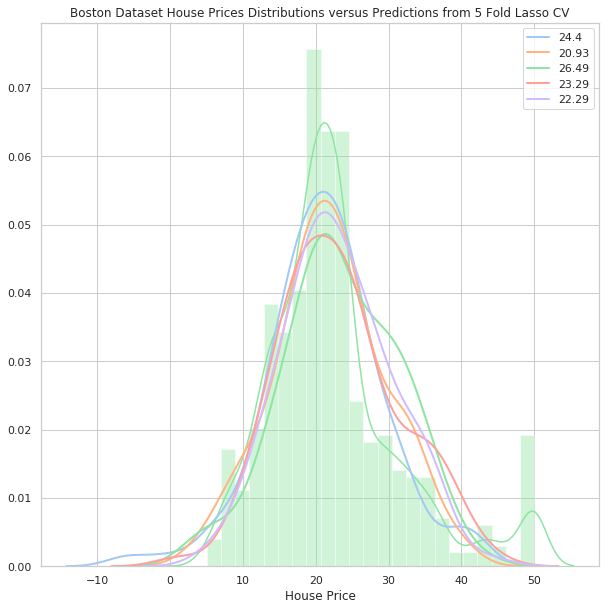

In [21]:
from scipy.stats import norm,lognorm
sns.set(style="whitegrid", palette="pastel", color_codes=True)

plt.figure(figsize=(10,10))
plt.title("Boston Dataset House Prices Distributions versus Predictions from 5 Fold Lasso CV")
plt.xlabel('House Price')

sns.distplot(y, color='g')

for i,j in zip(range(len(boston_lasso_1_cv_predict)),boston_lasso_1_cv_mse):
    sns.distplot(boston_lasso_1_cv_predict[i], hist=False, kde_kws={"lw": 2, "label": round(j,2)})

plt.show()
#plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Lasso_CV_Predict.png', bbox_inches='tight')

## Filtered Outlier

### Hyperparameter Tuning

In [0]:
def mse_cv(model,X,y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5)
    return mse

In [23]:
# cross validation, alpha regularization
alphas = [0.0001,0.0005,0.001, 0.0025, 0.005, 0.01, 0.02]
cv_lasso_out = [mse_cv(Lasso(alpha=alpha, max_iter=10000), df_filtered[df_filtered.columns.values[0:-1]], df_filtered[df_filtered.columns.values[-1]]).mean() for alpha in alphas]
print("The minimum mean squared error is {} and it occurrs at regularization of {}".format(min(cv_lasso_out),alphas[np.argmin(cv_lasso_out)]))

The minimum mean squared error is 22.748383496270563 and it occurrs at regularization of 0.01


### Lasso CV Predictons with Outlier Removed

In [0]:
boston_lasso_2 = model(Lasso(alpha=0.01, selection='random', random_state=42),2,'lasso',df_filtered[df_filtered.columns.values[0:-1]].values, df_filtered[df_filtered.columns.values[-1]].values)

In [0]:
boston_lasso_2_cv_predict, boston_lasso_2_cv_mse, lasso_coef_2 = model_cross_validation(boston_lasso_2, 5)

In [26]:
boston_lasso_2_cv_mse

array([12.08073412, 19.68375801, 15.12152385, 17.68053279, 11.17149339])

In [27]:
boston_lasso_2_cv_mse.sum()/5

15.147608432454737

In [28]:
np.std(boston_lasso_2_cv_mse)/np.sqrt(5)

1.4451055062121858

In [29]:
max(boston_lasso_2_cv_mse)-min(boston_lasso_2_cv_mse)

8.512264625648173

In [30]:
dict(zip(boston.feature_names,lasso_coef_2))

{'AGE': -0.386531916735502,
 'B': 0.7606119418948968,
 'CHAS': 0.0860416543644944,
 'CRIM': -0.6982092230491099,
 'DIS': -2.4733770275674725,
 'INDUS': -0.20224122749204762,
 'LSTAT': -2.7855487067742604,
 'NOX': -1.5510817040645108,
 'PTRATIO': -1.791538449897999,
 'RAD': 2.206293824298481,
 'RM': 2.300950066359908,
 'TAX': -2.3711987150640996,
 'ZN': 0.7442058830913587}

FileNotFoundError: ignored

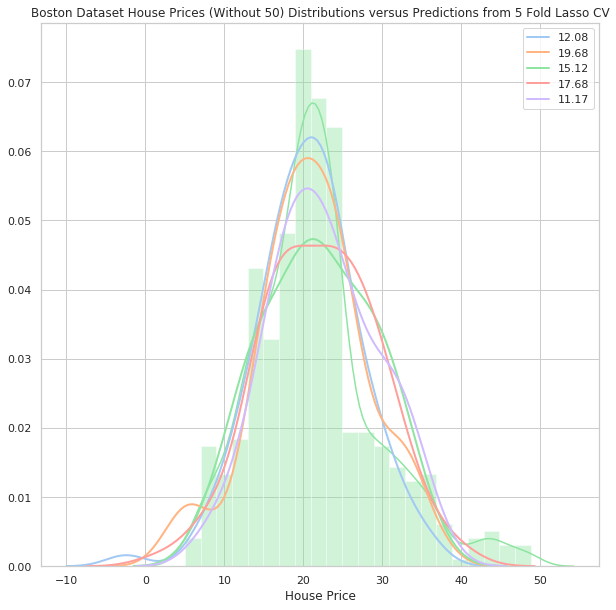

In [31]:
from scipy.stats import norm,lognorm
sns.set(style="whitegrid", palette="pastel", color_codes=True)

plt.figure(figsize=(10,10))
plt.title("Boston Dataset House Prices (Without 50) Distributions versus Predictions from 5 Fold Lasso CV")
plt.xlabel('House Price')

sns.distplot(df_filtered[df_filtered.columns.values[-1]].values, color='g')

for i,j in zip(range(len(boston_lasso_2_cv_predict)),boston_lasso_2_cv_mse):
    sns.distplot(boston_lasso_2_cv_predict[i], hist=False, kde_kws={"lw": 2, "label": round(j,2)})

plt.show()
#plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Lasso_CV_Predict_Filtered.png', bbox_inches='tight')

# Random Forest Model

## No Filtering for Outlier

### Hyperparameter Tuning

In [0]:
parameters = {'n_estimators':[200,300,400,500], 'max_features':[1,2,3,4,5,6,7]}
reg2 = RandomForestRegressor()
clf = GridSearchCV(reg2, parameters, cv=5, scoring="neg_mean_squared_error")
clf.fit(X,y)
clf.best_params_
-clf.best_score_

### Random Forest CV Predictions

In [0]:
boston_rf = model(RandomForestRegressor(n_estimators=500, max_features=7),1,'random',X,y)

In [0]:
boston_rf_1_cv_predict, boston_rf_1_cv_mse, random_features = model_cross_validation(boston_rf, 5)

In [0]:
boston_rf_1_cv_mse

In [0]:
boston_rf_1_cv_mse.sum()/5

In [0]:
np.std(boston_rf_1_cv_mse)/np.sqrt(5)

In [0]:
max(boston_rf_1_cv_mse) - min(boston_rf_1_cv_mse)

In [0]:
##dict(zip(boston.feature_names, rf_features))

In [0]:
plt.figure(figsize=(10,10))
plt.title("Boston Dataset House Prices Distribution Versus Predictions from 5 Fold Random Forest CV")
plt.xlabel("House Price")

sns.distplot(y, color='g')

for i,j in zip(range(len(boston_rf_1_cv_predict)), boston_rf_1_cv_mse):
    ax = sns.distplot(boston_rf_1_cv_predict[i], hist=False, kde_kws={"lw": 2, "label": round(j,2)})

plt.show()    
#plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Random_Forest_CV_Predict.png', bbox_inches='tight')

## Filtering for Outlier

In [45]:
parameters = {'n_estimators':[200,300,400,500], 'max_features':[1,2,3,4,5,6,7]}
reg3 = RandomForestRegressor()
clf = GridSearchCV(reg3, parameters, cv=5, scoring="neg_mean_squared_error")
clf.fit(df_filtered[df_filtered.columns.values[0:-1]].values, df_filtered[df_filtered.columns.values[-1]].values)
clf.best_params_
-clf.best_score_

14.577661146285763

In [33]:
df_filtered.head()
df_filtered.shape

(490, 14)

In [34]:
df_filtered.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,SALEPRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [35]:
df_filtered[df_filtered.columns.values[0:-1]].values

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [36]:
df_filtered[df_filtered.columns.values[-1]].values

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

### Random Forest Predictions without Outlier

In [0]:
boston_rf_2 = model(RandomForestRegressor(n_estimators=400, max_features=6),2,'random',df_filtered[df_filtered.columns.values[0:-1]].values, df_filtered[df_filtered.columns.values[-1]].values)

In [0]:
boston_rf_2_cv_predict, boston_rf_2_cv_mse, random_features_2 = model_cross_validation(boston_rf_2, 5)

In [39]:
boston_rf_2_cv_mse

array([5.89425351, 9.36104955, 8.25100512, 7.65424091, 5.37183455])

In [40]:
boston_rf_2_cv_mse.sum()/5

7.306476730229588

In [41]:
np.std(boston_rf_2_cv_mse)/np.sqrt(5)

0.6624668469489046

In [42]:
max(boston_rf_2_cv_mse) - min(boston_rf_2_cv_mse)

3.9892149999999544

In [0]:
##dict(zip(boston.feature_names,rf_features))

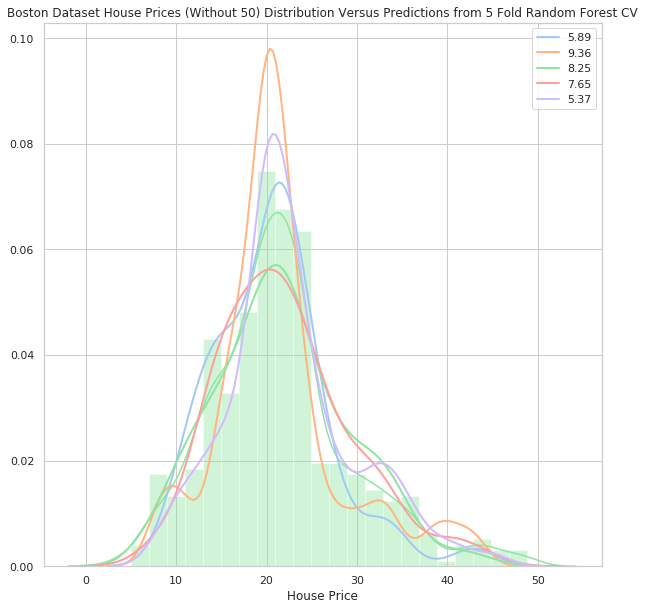

In [44]:
plt.figure(figsize=(10,10))
plt.title("Boston Dataset House Prices (Without 50) Distribution Versus Predictions from 5 Fold Random Forest CV")
plt.xlabel("House Price")

sns.distplot(df_filtered[df_filtered.columns.values[-1]].values, color='g')

for i,j in zip(range(len(boston_rf_2_cv_predict)), boston_rf_2_cv_mse):
    ax = sns.distplot(boston_rf_2_cv_predict[i], hist=False, kde_kws={"lw": 2, "label": round(j,2)})

plt.show()    
#plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Random_Forest_CV_Predict_filtered.png', bbox_inches='tight')